## Joke Generator with Review

In [80]:
import os
from dotenv import load_dotenv

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command

from langgraph.checkpoint.memory import MemorySaver

from langchain_openai import ChatOpenAI


from IPython.display import display, Markdown, Image

In [3]:
load_dotenv("../.env")

True

## 1. Joke Generator with Review
    - takes in a topic and generates a joke
    - revises the joke twice
    - Asks human for final review

In [4]:
llm = ChatOpenAI(
    temperature=0,
    model="gpt-4o-mini",
    max_tokens=500,
    openai_api_key=os.environ["OPENAI_API_KEY"],
)

In [44]:
class State(TypedDict):
    topic: str
    joke: str
    num_revisions: int

In [48]:
def check_num_revisions(state: State):
    if state["num_revisions"] > 1:
        return "revision_limit_reached"
    return "revise"


def generate_or_revise_joke(state: State):
    if state["num_revisions"] == 0:
        return {
            "joke": llm.invoke(
                f"Write a joke about {state['topic']} with a set up and punchline."
            ),
            "num_revisions": state["num_revisions"] + 1
        }
    else:
        return {
            "joke": llm.invoke(
                f"Revise the joke: {state['joke']}. Refine and make it edgier."
            ),
            "num_revisions": state["num_revisions"] + 1
        }
        
        
graph_builder = StateGraph(State)
graph_builder.add_node("generate_or_revise_joke", generate_or_revise_joke)

graph_builder.add_edge(START, "generate_or_revise_joke")
graph_builder.add_conditional_edges(
    "generate_or_revise_joke",
    check_num_revisions,
    {"revise": "generate_or_revise_joke", "revision_limit_reached": END}
)

graph = graph_builder.compile()

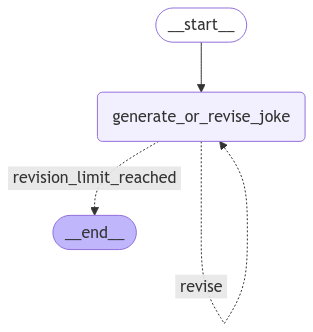

In [49]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
topic = "political correctness"

events = graph.stream(
    {"topic": topic, "num_revisions": 0},
    config = {"configurable": {"thread_id": "1"}},
    stream_mode="values",
)
for event in events:
    if "joke" in event:
        event["joke"].pretty_print()

================================== Ai Message ==================================

Why did the politically correct scarecrow win an award?

Because he was outstanding in his field of sensitivity!
================================== Ai Message ==================================

Why did the politically correct scarecrow get an award?

Because he was truly outstanding in his field—of avoiding all the crows!


## Joke Generator

- suggests topics 
- takes human selected topic
- generates a jokes 
- asks human approval
  - approval : End
  - suggestion : takes in suggestion and revise

In [51]:
llm = ChatOpenAI(
    temperature=0,
    model="gpt-4o-mini",
    max_tokens=500,
    openai_api_key=os.environ["OPENAI_API_KEY"],
)

In [142]:
class State(TypedDict):
    topic_list: list[str]
    topic: str
    approval: str
    current_joke: str
    final_joke: str

In [165]:
def generate_topics(state: State):
    return {
        "topic_list": llm.invoke(
            "Generate a list of 5 topics for a joke that can lead to a hilarious joke."
        )
    }

def generate_or_revise_joke(state: State):
    if "approval" not in state:
        return {
            "current_joke": llm.invoke(
                f"Write a joke about {state['topic']} with a set up and punchline."
            ).content
        }
    else:
        return {
            "current_joke": llm.invoke(
                f"Revise the joke: {state['current_joke']}. Refine and make it edgier."
            ).content,
        }
    
def human_topic_selection(state: State):
    value = interrupt(
        f"Please choose a topic from the following list: {state['topic_list']}. Or suggest some other topic.",
    )
    return {"topic": value}


def human_joke_approval(state: State):
    value = interrupt(f"Please approve the joke: {state['current_joke']}. Reply with yes or no.")
    return {"approval": value}


def check_human_joke_approval(state: State):
    if state["approval"].lower() == "yes":
        return "joke_approved"
    return "revise"

def finalize_joke(state: State):
    return {"final_joke": state["current_joke"]}

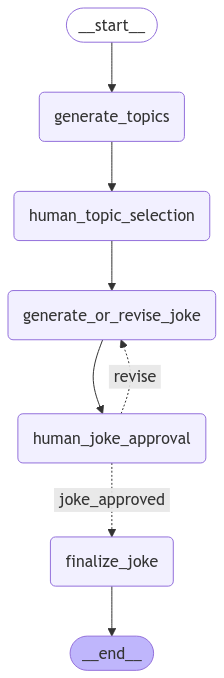

In [166]:
graph_builder = StateGraph(State)
graph_builder.add_node("generate_topics", generate_topics)
graph_builder.add_node("human_topic_selection", human_topic_selection)
graph_builder.add_node("generate_or_revise_joke", generate_or_revise_joke)
graph_builder.add_node("human_joke_approval", human_joke_approval)
graph_builder.add_node("finalize_joke", finalize_joke)

graph_builder.add_edge(START, "generate_topics")
graph_builder.add_edge("generate_topics", "human_topic_selection")
graph_builder.add_edge("human_topic_selection", "generate_or_revise_joke")
graph_builder.add_edge("generate_or_revise_joke", "human_joke_approval")
graph_builder.add_conditional_edges(
    "human_joke_approval",
    check_human_joke_approval,
    {"joke_approved": "finalize_joke", "revise": "generate_or_revise_joke"}
)
graph_builder.add_edge("finalize_joke", END)

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [167]:
config = {"configurable": {"thread_id": "1"}}

In [168]:
# events = graph.stream(
#     {"topic_list": []},
#     config=config,
#     stream_mode="values",
# )
# keys = ["joke", "topic", "approval", "topic_list"]
# for event in events:
#     for key in keys:
#         if key in event:
#             try:
#                 event[key].pretty_print()
#             except:
#                 print(f"{key}: {event[key]}")


# human_response = "Technology fails."

# human_command = Command(resume=human_response)

# events = graph.stream(human_command, config, stream_mode="values")

# keys = ["topic_list", "topic", "approval", "joke"]
# for event in events:
#     for key in keys:
#         if key in event:
#             try:
#                 event[key].pretty_print()
#             except:
#                 print(f"{key}: {event[key]}")
                
# human_response = "Yes"

# human_command = Command(resume=human_response)

# events = graph.stream(human_command, config, stream_mode="values")

# keys = ["topic_list", "topic","joke", "approval"]
# for event in events:
#     for key in keys:
#         if key in event:
#             try:
#                 event[key].pretty_print()
#             except:
#                 print(f"{key}: {event[key]}")

In [169]:
result = graph.invoke({"topic_list": []},config=config,)
print(result.keys())
print(result)

dict_keys(['topic_list'])
{'topic_list': AIMessage(content='Sure! Here are five topics that can lead to some hilarious jokes:\n\n1. **Cats vs. Dogs** - The classic rivalry between pet personalities and their antics.\n2. **Technology Fails** - The humorous side of gadgets and apps that don’t work as intended.\n3. **Cooking Disasters** - The funny mishaps that happen in the kitchen when trying to follow a recipe.\n4. **Awkward First Dates** - The cringe-worthy moments that can happen when meeting someone new.\n5. **Office Life** - The quirks and absurdities of working in a corporate environment.\n\nFeel free to pick one, and I can help you craft a joke!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 25, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens

In [170]:
result = graph.invoke(Command(resume="Technology Fails"), config=config,)
result

{'topic_list': AIMessage(content='Sure! Here are five topics that can lead to some hilarious jokes:\n\n1. **Cats vs. Dogs** - The classic rivalry between pet personalities and their antics.\n2. **Technology Fails** - The humorous side of gadgets and apps that don’t work as intended.\n3. **Cooking Disasters** - The funny mishaps that happen in the kitchen when trying to follow a recipe.\n4. **Awkward First Dates** - The cringe-worthy moments that can happen when meeting someone new.\n5. **Office Life** - The quirks and absurdities of working in a corporate environment.\n\nFeel free to pick one, and I can help you craft a joke!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 25, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt

In [171]:
result = graph.invoke(Command(resume="No"), config=config,)
result

{'topic_list': AIMessage(content='Sure! Here are five topics that can lead to some hilarious jokes:\n\n1. **Cats vs. Dogs** - The classic rivalry between pet personalities and their antics.\n2. **Technology Fails** - The humorous side of gadgets and apps that don’t work as intended.\n3. **Cooking Disasters** - The funny mishaps that happen in the kitchen when trying to follow a recipe.\n4. **Awkward First Dates** - The cringe-worthy moments that can happen when meeting someone new.\n5. **Office Life** - The quirks and absurdities of working in a corporate environment.\n\nFeel free to pick one, and I can help you craft a joke!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 25, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt

In [172]:
result = graph.invoke(Command(resume="Yes"), config=config,)
result

{'topic_list': AIMessage(content='Sure! Here are five topics that can lead to some hilarious jokes:\n\n1. **Cats vs. Dogs** - The classic rivalry between pet personalities and their antics.\n2. **Technology Fails** - The humorous side of gadgets and apps that don’t work as intended.\n3. **Cooking Disasters** - The funny mishaps that happen in the kitchen when trying to follow a recipe.\n4. **Awkward First Dates** - The cringe-worthy moments that can happen when meeting someone new.\n5. **Office Life** - The quirks and absurdities of working in a corporate environment.\n\nFeel free to pick one, and I can help you craft a joke!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 25, 'total_tokens': 162, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt

## 3. Joke with help of search engine
- search internet for hot topics or news controversies
- selects 5 topics 
- generates 5 jokes (simultaneously)
- checks every joke for norms
- compares jokes
- gives the final joke